# Description

## Background & Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help


## Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

## Data Dictionary 

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

## Data Dictionary

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Importing necessary libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

<IPython.core.display.Javascript object>

## Load and review data

Load data set from "Credit Card Customer Data" excel sheet and review both structure and relevance of the data.

In [2]:
# Load data from the excel sheet.
data = pd.read_excel("Credit Card Customer Data.xlsx", sheet_name="Sheet1")

# creating a copy of the data so that original data remains unchanged
custData = data.copy()

<IPython.core.display.Javascript object>

In [3]:
# Sampling 20 random rows
# Random seed via np.random.seed is set so that
# same random results are displayed every time
np.random.seed(1)
custData.sample(n=20)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


<IPython.core.display.Javascript object>

In [4]:
# Load only customer attributes relevent to clustering.
# Discarding S.NO and Customer Key

custDataAttr = custData.iloc[:, 2:]
custDataAttr.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


<IPython.core.display.Javascript object>

### List of column data types in the dataset.

In [5]:
# check the summary of the custDataAttr data frame.

custDataAttr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


<IPython.core.display.Javascript object>

**Observations**

- There are no null values.

### Duplicate rows treatment 

Identify and delete duplicate rows.

In [6]:
# Check if there are any duplicated rows using duplicated method.

custDataAttr.duplicated().sum()

11

<IPython.core.display.Javascript object>

**Observations**

- There are around 11 duplicate observation.
- Though they belong to different customers, we can delete these values as they don't add any value.
- Now there are only 649 observations.

In [7]:
# Deleting all the duplicate values

custDataAttr = custDataAttr[(~custDataAttr.duplicated())].copy()
custDataAttrIQR = custDataAttr.copy()

<IPython.core.display.Javascript object>

### Missing row treatment

Identify missing rows and impute, if needed.

In [8]:
""" Function to check missing values count and its percentage"""


def missing_check(df):
    total = (
        df.isnull().sum().sort_values(ascending=False)
    )  # total number of null values
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(
        ascending=False
    )  # percentage of values that are null
    missing_data = pd.concat(
        [total, percent], axis=1, keys=["Total", "Percent"]
    )  # putting the above two together
    return missing_data  # return the dataframe

<IPython.core.display.Javascript object>

In [9]:
missing_check(custDataAttr)

,Total,Percent
Avg_Credit_Limit,0,0.0
Total_Credit_Cards,0,0.0
Total_visits_bank,0,0.0
Total_visits_online,0,0.0
Total_calls_made,0,0.0


<IPython.core.display.Javascript object>

**Observations**

- There are no missing values.

### Data summary exploration

Explore summary statistics for allLife bank data set.

In [10]:
#  Generate descriptive statistics using describe method.

custDataAttr.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,649.0,34878.274268,37813.736638,3000.0,11000.0,18000.0,49000.0,200000.0
Total_Credit_Cards,649.0,4.708783,2.173763,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,649.0,2.397535,1.625148,0.0,1.0,2.0,4.0,5.0
Total_visits_online,649.0,2.624037,2.952888,0.0,1.0,2.0,4.0,15.0
Total_calls_made,649.0,3.590139,2.877911,0.0,1.0,3.0,5.0,10.0


<IPython.core.display.Javascript object>

**Observations**

- Avg_Credit_Limit is skewed heavily to the right with average of 37.8 K is greater than Median of 18 K.
- Extreme value 200 K in Avg_Credit_Limit indicates outliers.
- Total_Credit_Cards, Total_visits_bank, Total_visits_online and Total_calls_made is more or less distributed uniformly as mean and median is close.
- High max values for Total_Credit_Cards, Total_visits_online and Total_calls_made indicates outliers.

### Outlier Treatment

Identify outliers and treat it if needed

For this analysis any data points above 4 times of IQR is considers as outliers.

In [11]:
# This function helps to identify outlier for a given column.


def IQR4(column, cname):
    """Gives list that is greater than
    4 times inter quartile range.
    """
    quartiles = np.quantile(column[column.notnull()], [0.25, 0.75])
    power_4iqr = 4 * (quartiles[1] - quartiles[0])
    print(f"Q1 = {quartiles[0]}, Q3 = {quartiles[1]},4*IQR = {power_4iqr}")
    outlier_powers = custDataAttr.loc[
        np.abs(column - column.median()) > power_4iqr, cname
    ]
    return outlier_powers


def IQR4Value(column, cname):
    """Gives list that is greater than
    4 times inter quartile range.
    """
    quartiles = np.quantile(column[column.notnull()], [0.25, 0.75])
    power_4iqr = 4 * (quartiles[1] - quartiles[0])
    return power_4iqr

<IPython.core.display.Javascript object>

In [12]:
# Looping through each column of the data frame to find outliers.

for column in custDataAttr:
    print(IQR4(custDataAttr[column], column))

Q1 = 11000.0, Q3 = 49000.0,4*IQR = 152000.0
622    176000
624    178000
630    200000
631    195000
632    187000
637    173000
639    184000
645    171000
646    186000
647    183000
650    195000
654    172000
658    172000
Name: Avg_Credit_Limit, dtype: int64
Q1 = 3.0, Q3 = 6.0,4*IQR = 12.0
Series([], Name: Total_Credit_Cards, dtype: int64)
Q1 = 1.0, Q3 = 4.0,4*IQR = 12.0
Series([], Name: Total_visits_bank, dtype: int64)
Q1 = 1.0, Q3 = 4.0,4*IQR = 12.0
620    15
622    15
628    15
631    15
639    15
640    15
644    15
645    15
653    15
658    15
Name: Total_visits_online, dtype: int64
Q1 = 1.0, Q3 = 5.0,4*IQR = 16.0
Series([], Name: Total_calls_made, dtype: int64)


<IPython.core.display.Javascript object>

**Observations**

- 13 outliers are identified in Avg_Credit_Limit.
- 11 outliers are identified in Total_visits_online.
- **These outliers will not be treat for clustering analysis. However, an appendix is added for KMeans analysis with outlier treatment to see changes in the clustering.**

## Exploratory data analysis.

Detailed exploration of data using charts and diagrams to identify insights within the data.

## Univariate Analysis

Univariate analysis refer to the analysis of a single variable. The main purpose of univariate analysis is to summarize and find patterns in the data. The key point is that there is only one variable involved in the analysis.

In [13]:
# function to plot a boxplot and a histogram along the same scale.

# Histograms give a good sense of the distribution of a variable.

# Box plot to tell if the distribution is symmetric or skewed and its central value, its variability, etc.


def histogram_boxplot(data, feature, figsize=(12, 5), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

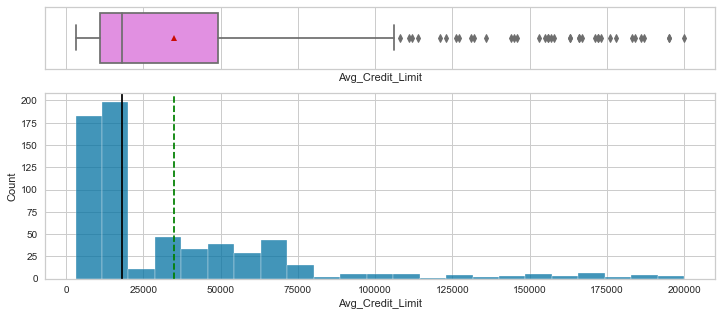

<IPython.core.display.Javascript object>

In [14]:
# selecting numerical columns
num_col = custDataAttr.select_dtypes(include=np.number).columns.tolist()

histogram_boxplot(custDataAttr, "Avg_Credit_Limit")

**Observations**

- Avg_Credit_Limit has many outliers.

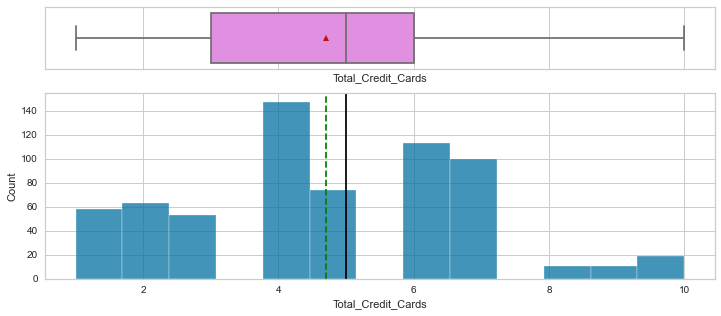

<IPython.core.display.Javascript object>

In [15]:
histogram_boxplot(custDataAttr, "Total_Credit_Cards")


**Observations**

- Total_Credit_Cards seems uniformly distributed.

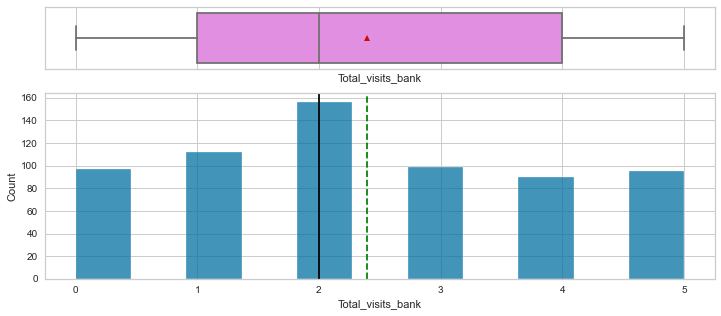

<IPython.core.display.Javascript object>

In [16]:
histogram_boxplot(custDataAttr, "Total_visits_bank")


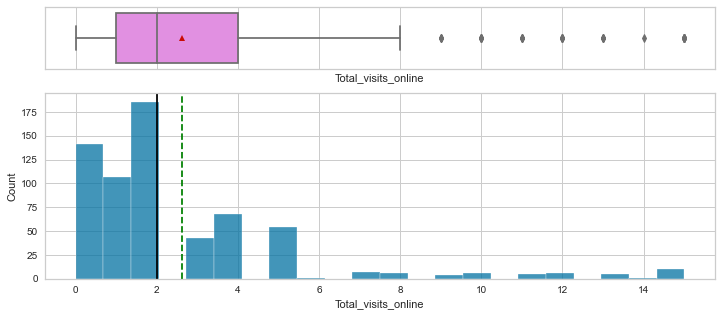

<IPython.core.display.Javascript object>

In [17]:
histogram_boxplot(custDataAttr, "Total_visits_online")


**Observations**

- Majority customers doesn't use online banking.

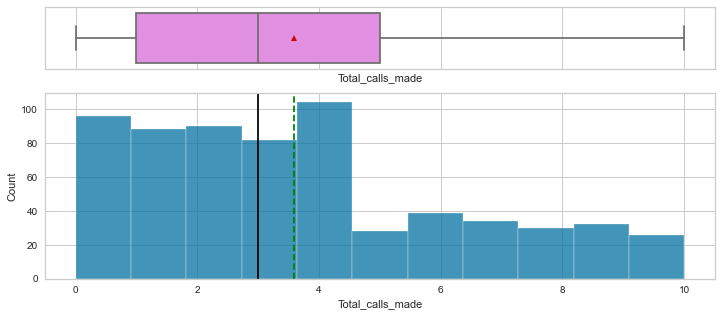

<IPython.core.display.Javascript object>

In [18]:
histogram_boxplot(custDataAttr, "Total_calls_made")

**Observations**

- Around 65% of the observation has less than 5 total call made.


### Cumulative distribution function (CDF) 

CDF plot to show the empirical cumulative distribution of the data.

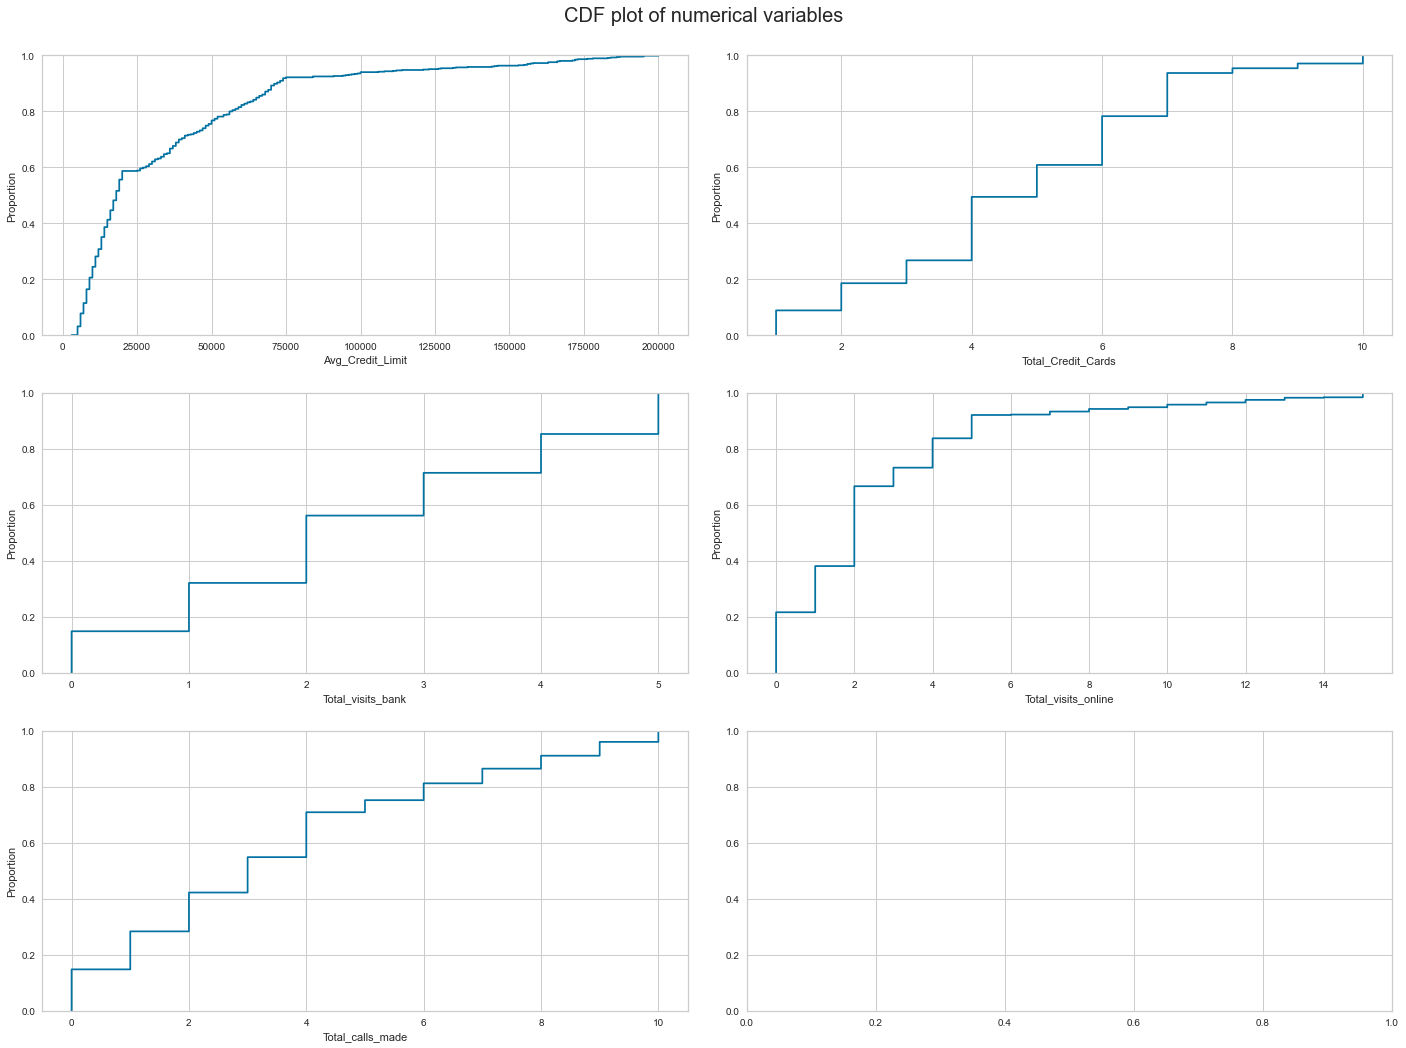

<IPython.core.display.Javascript object>

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=custDataAttr[num_col[counter]])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1], x=custDataAttr[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

**Observations**

- Around 60% of customer visits bank for at-least 3 times.
- Around 65% of the customer have average credit limit of 25 K.
- Around 60% of customer has average of 6 credit cards.
- Around 80% of the customers visited online less than 4 times per year.
- Around 80% of the customers made less than 6 calls per year.

### Further analysis on Total_visits_bank, Total_calls_made and Total_visits_online

Let's do bar plot that represents an estimate of central tendency

In [20]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

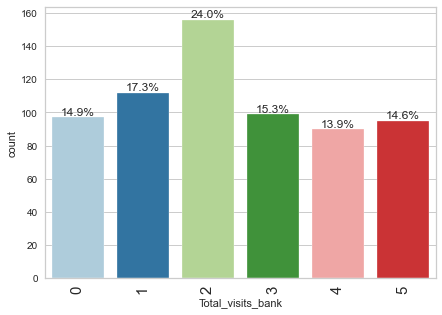

<IPython.core.display.Javascript object>

In [21]:
# let's explore Total_visits_bank further
labeled_barplot(custDataAttr, "Total_visits_bank", perc=True)

In [22]:
custDataAttr.groupby("Total_visits_bank").mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_online,Total_calls_made
Total_visits_bank,,,,
0,40134.020619,3.577320,5.092784,5.835052
1,47544.642857,4.303571,5.562500,5.178571
2,25750.000000,4.237179,1.910256,4.019231
3,35474.747475,5.575758,1.030303,2.000000
4,33533.333333,5.444444,1.055556,1.833333
5,30221.052632,5.515789,0.957895,2.042105


<IPython.core.display.Javascript object>

- Around 15% of customers never visits bank.
- These customers uses on-line and phone services for banking.

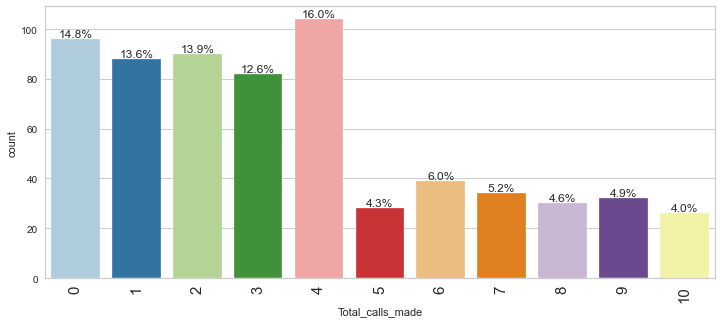

<IPython.core.display.Javascript object>

In [23]:
# let's explore Total_calls_made further
labeled_barplot(custDataAttr, "Total_calls_made", perc=True)

In [24]:
custDataAttr.groupby("Total_calls_made").mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online
Total_calls_made,,,,
0,55020.833333,5.968750,2.979167,2.593750
1,47750.000000,5.988636,3.079545,2.647727
2,55911.111111,6.111111,2.800000,3.033333
3,35426.829268,5.609756,3.500000,1.268293
4,28067.307692,4.721154,2.692308,1.567308
5,11678.571429,2.464286,1.000000,3.571429
6,11897.435897,2.564103,1.128205,3.564103
7,11676.470588,2.294118,0.941176,3.294118
8,12300.000000,2.366667,0.966667,3.700000


<IPython.core.display.Javascript object>

- 70% of the customers made calls 4 or less time per year.
- 30% of the customers who visits bank more than 5 times a year has very low credit limit. (11 K average)

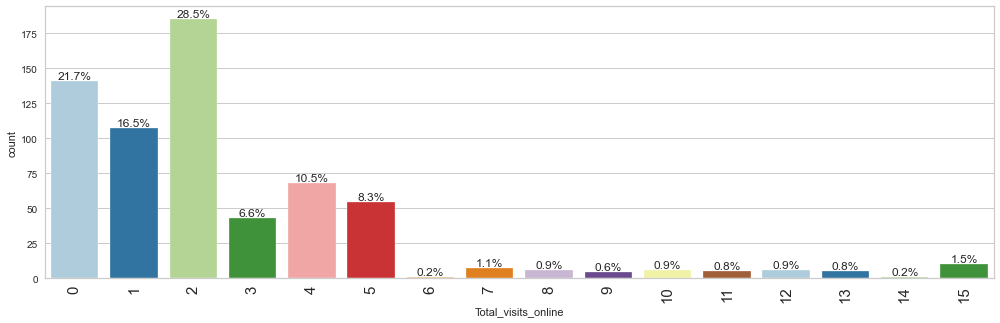

<IPython.core.display.Javascript object>

In [25]:
# let's explore Total_visits_online further
labeled_barplot(custDataAttr, "Total_visits_online", perc=True)

In [26]:
custDataAttr.groupby("Total_visits_online").mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_calls_made
Total_visits_online,,,,
0,35446.808511,5.553191,3.496454,2.049645
1,34074.766355,5.429907,3.242991,1.990654
2,25881.081081,4.572973,2.859459,3.318919
3,13395.348837,2.604651,1.000000,7.000000
4,12808.823529,2.514706,0.911765,6.911765
5,12129.629630,2.277778,0.962963,7.037037
6,91000.000000,8.000000,1.000000,1.000000
7,149857.142857,8.428571,0.714286,0.857143
8,130666.666667,8.666667,0.500000,0.833333


<IPython.core.display.Javascript object>

- There are around 5% of customers who uses online heavily.
- ALL those customers has very high credit limit. (130 K +)
- These customers has more credit cards (8 +)

## Bivariate Analysis

Multivariate analysis is performed to understand interactions between different fields in the dataset (or) finding interactions between variables more than 2

### Correlation check

Heatmap is a great way to visualize data, because it can show the relation between variabels in a color-encoded matrix

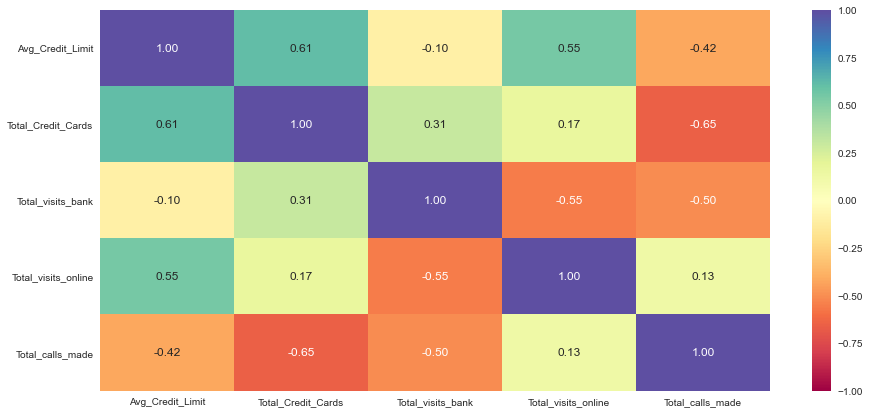

<IPython.core.display.Javascript object>

In [27]:
plt.figure(figsize=(15, 7))
sns.heatmap(
    custDataAttr[num_col].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cmap="Spectral",
)
plt.show()

**Observations**

- "Total visits", "Total visits online" and "Total calls made" columns are negatively co-related to each other.
- This means customers stick to one channel of banking and don't change often.
- More credit cards means more credit limit.
- Customers with higher credit limit uses online channel for their banking needs.
- Customers with many credit cards don't use phone banking.

### Plot pairwise relationships

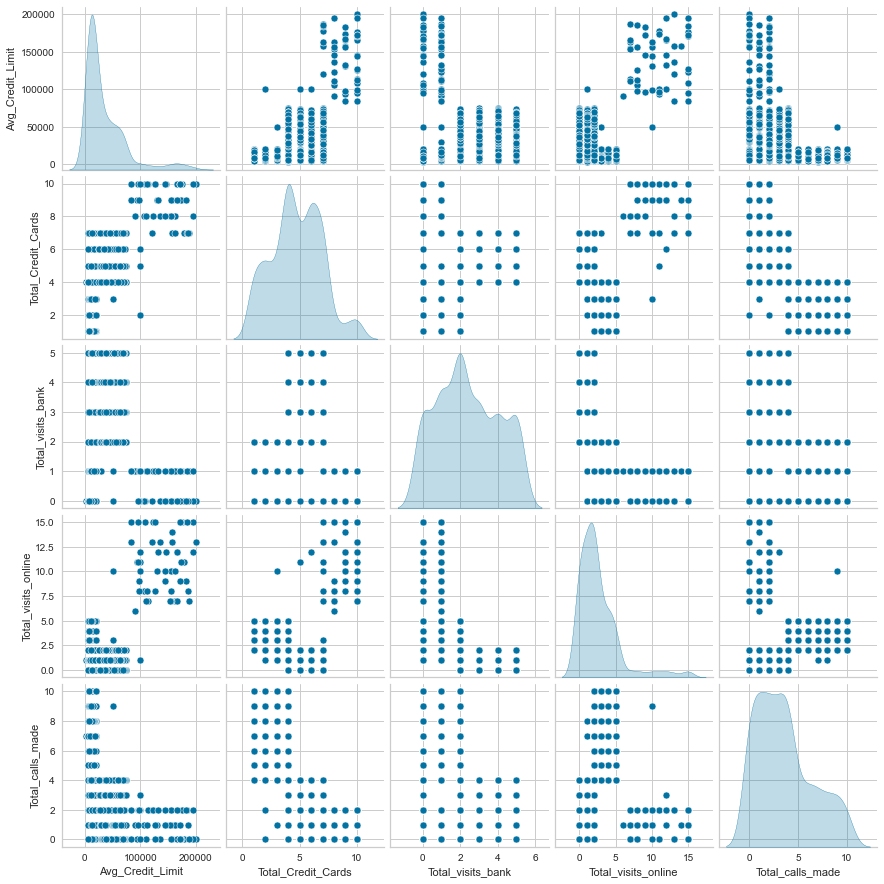

<IPython.core.display.Javascript object>

In [28]:
sns.pairplot(data=custDataAttr[num_col], diag_kind="kde")
plt.show()

**Observations**

- Customers with less credit cards use phone banking.
- Customers with less credit don't use online banking.

## Data Preprocessing

During the data preparation stage, raw data is transformed into an easily digestible format for efficient ML algorithms. Then, all features in the data set are normalized to the same scale (unit) for clustering.

- There are no missing values, so no treatment is necessary.
- There are outliers in credit limit and online visit columns. These outliers will not be treat for clustering analysis.
- However, an appendix is added for KMeans analysis with outlier treatment to see changes in the clustering.
- All the duplicate rows are removed.

In [29]:
# variables used for clustering
num_col

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

<IPython.core.display.Javascript object>

In [30]:
# scaling the dataset before clustering
scaler = StandardScaler()
subset = custDataAttr[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

<IPython.core.display.Javascript object>

In [31]:
# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

<IPython.core.display.Javascript object>

In [32]:
# Cloning the data set for resuse during hierarichal clusturing analysis.
custDataAttrHC = custDataAttr.copy()
subset_scaled_dfHC = subset_scaled_df.copy()

<IPython.core.display.Javascript object>

In [33]:
np.random.seed(1)
subset_scaled_df.sample(n=20)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
440,0.029687,-0.326314,0.371000,-0.211494,-0.205216
242,-0.658424,-0.326314,-0.244803,-0.550407,-1.248443
465,0.267880,0.134072,1.602607,-0.211494,-0.552958
347,-0.526095,0.134072,-0.244803,-0.889320,-1.248443
474,-0.182039,0.134072,0.986803,-0.550407,-0.900701
464,0.082619,-0.326314,0.371000,-0.550407,0.142526
214,-0.631958,-0.326314,-1.476410,-0.211494,0.490268
380,-0.605492,0.134072,0.986803,-0.211494,-0.900701
116,-0.446697,-1.707474,-1.476410,-0.211494,1.185753
633,2.438076,2.436005,-0.860606,4.194372,-0.900701


<IPython.core.display.Javascript object>

## K-means Clustering

K-means is a centroid-based algorithm, or a distance-based algorithm, where distances are calculated to assign a point to a cluster. In K-Means, each cluster is associated with a centroid.

The main objective of the K-Means algorithm is to minimize the sum of distances between the points and their respective cluster centroid.

Optimum number of clusters is identified using elbow curve, where the x-axis will represent the number of clusters and the y-axis will be an evaluation metric (pair-wise distances).

Number of Clusters: 1 	Average Distortion: 2.007896349270688
Number of Clusters: 2 	Average Distortion: 1.4576197022077821
Number of Clusters: 3 	Average Distortion: 1.1434401208195095
Number of Clusters: 4 	Average Distortion: 1.0435538595477063
Number of Clusters: 5 	Average Distortion: 0.9877876331280893
Number of Clusters: 6 	Average Distortion: 0.9404952836425913
Number of Clusters: 7 	Average Distortion: 0.9081767500625029
Number of Clusters: 8 	Average Distortion: 0.8878693158146816


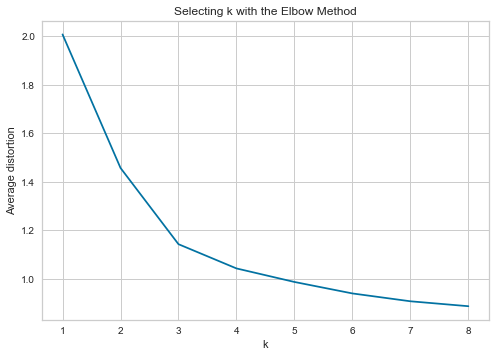

<IPython.core.display.Javascript object>

In [34]:
# Running 8 kmeans model with different cluster parameter to find optimal n_clusters value.

clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

**Appropriate value for k seems to be 3 or 4.**

Elbow curve indicates beyond 3 or 4 clusters, model starting to capture noise.

**Silhouette scores comparison**

Silhouette analysis is used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters visually like number of clusters.

For n_clusters = 2, the silhouette score is 0.41800025566689647)
For n_clusters = 3, the silhouette score is 0.516281010855363)
For n_clusters = 4, the silhouette score is 0.3570238219413198)
For n_clusters = 5, the silhouette score is 0.2723299188401586)
For n_clusters = 6, the silhouette score is 0.2570813252005605)
For n_clusters = 7, the silhouette score is 0.24960017409628557)
For n_clusters = 8, the silhouette score is 0.22556732935407947)
For n_clusters = 9, the silhouette score is 0.20962372342189262)


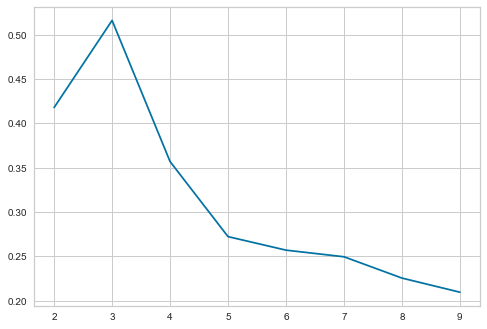

<IPython.core.display.Javascript object>

In [35]:
# Compute the Silhouette Coefficient of all samples and plot to see which one performs better.

sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

Silhouette score 1 means distinct cluster, 0 means close cluster, with border being shared and -1 is the the overlapping cluster. 

**Silhouette score for 3 is highest. So, we will choose 3 as value of k.**

### Silhouette Visualizer

The Silhouette Visualizer displays the silhouette coefficient for each sample on a per-cluster basis, visualizing which clusters are dense and which are not.

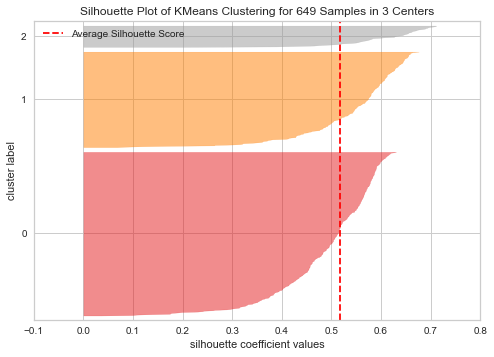

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 649 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [36]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

Clearly three distinct clusters with good density thickness and silhouette score.

In [37]:
# let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=0)

<IPython.core.display.Javascript object>

In [38]:
# adding kmeans cluster labels to the original and scaled dataframes

custDataAttr["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

## Cluster Profiling

The goal of Profiling is to differentiate groups (Each group must have unique characteristics.).

In [39]:
cluster_profile = custDataAttr.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [40]:
cluster_profile["count_in_each_segments"] = (
    custDataAttr.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [41]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,
0,34071.428571,5.518519,3.484127,0.981481,1.992063,378
1,12239.819005,2.411765,0.945701,3.561086,6.891403,221
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

There are tree distinct cluster with clearly 3 unique characteristics.

### Plotting 3 clusters against the scaled and original dataset to visualize the distribution.

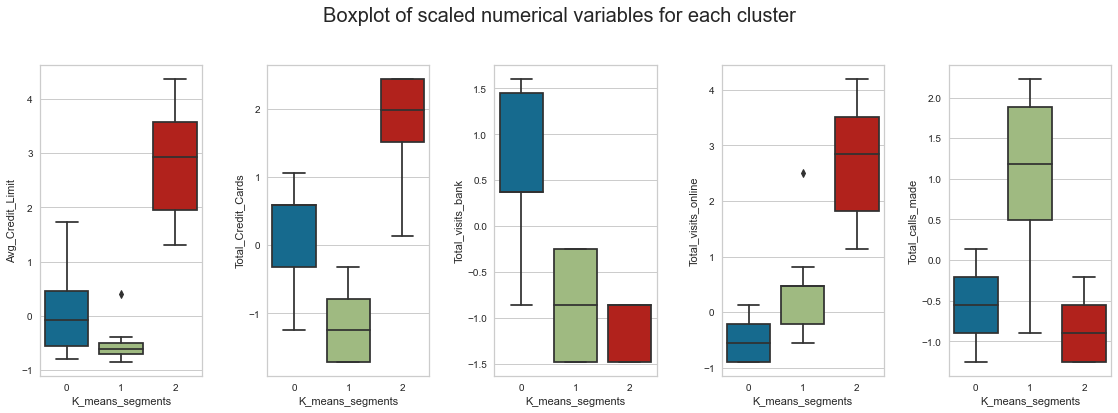

<IPython.core.display.Javascript object>

In [42]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

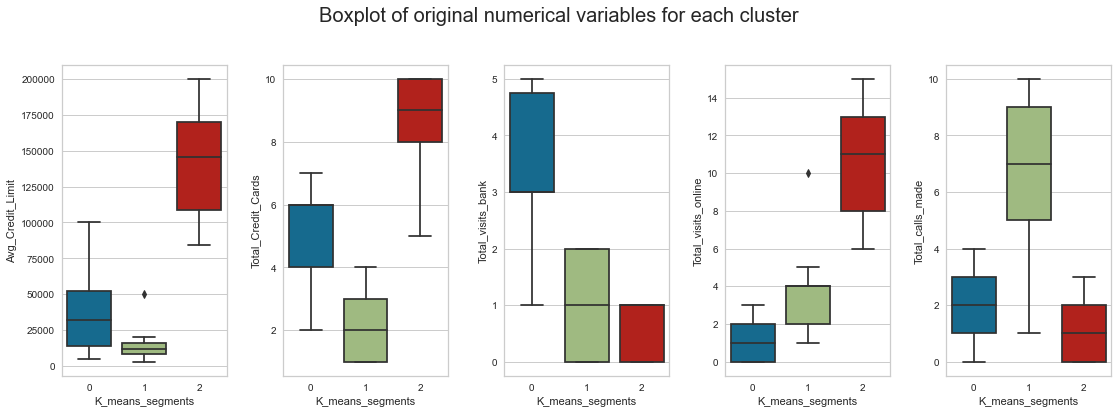

<IPython.core.display.Javascript object>

In [43]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=custDataAttr[num_col[counter]],
        x=custDataAttr["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

## Insights

- **Cluster 0 (Gold)**:
    - This customer cluster have average credit of 35K - 50K and have 5-6 credit card on an average.
    - These customers prefers personal touch and visits **financial center** more often (3 -5 times a year).
    - These cluster of customers rarely uses on-line banking and sometimes calls customer banking facility.
    - This cluster of customers can be branded as 'Gold' customers


- **Cluster 1 (Silver)**:
    - This customer cluster have average credit 11K - 12K, on the lower end, and have only 2-3 credit cards.
    - These customers prefers **phone banking**, which they make at-least 7 - 8 times a year.
    - These cluster of customers rarely uses on-line banking or visits banking facility.
    - This cluster of customers can be branded as 'Silver' customers


- **Cluster 2 (Platinum)**:
    - This customer cluster have average credit 140K - 150K and have around 8-10 credit card.
    - They visit banking center infrequently and use **online banking** for their needs.
    - They uses phone baking very rarely (1-2 times a year)
    - This cluster of customers can be branded as 'Platinum' customers

## Hierarchical Clustering

Hierarchical cluster analysis or HCA is an unsupervised clustering algorithm which creates clusters in a hierarchical format (top -> down or bottom -> up). Similar objects grouped into clusters. 

### Identify best distance and linkage using cophenet metrics.

Cophenetic calculates the distances between each observation in the hierarchical clustering defined by the linkage.

In [44]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_dfHC, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_dfHC))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7395135051413775.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8794736468795109.
Cophenetic correlation for Euclidean distance and average linkage is 0.8974425535306298.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8551098644586315.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7379112982920528.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8578617029322211.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8960370054789858.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.893309534644998.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7054746377393306.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6513369047977687.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8330283182400025.
Cophenetic cor

<IPython.core.display.Javascript object>

In [45]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8974425535306298, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

### Explore different linkage methods with Euclidean distance.

With selected Euclidean distance measure calculate cophenet for other linkages including centroid, ward, weighted. 

In [46]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_dfHC, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_dfHC))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7395135051413775.
Cophenetic correlation for complete linkage is 0.8794736468795109.
Cophenetic correlation for average linkage is 0.8974425535306298.
Cophenetic correlation for centroid linkage is 0.894471288720818.
Cophenetic correlation for ward linkage is 0.7425813590948763.
Cophenetic correlation for weighted linkage is 0.8551098644586315.


<IPython.core.display.Javascript object>

In [47]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8974425535306298, which is obtained with average linkage.


<IPython.core.display.Javascript object>

### Dendrogram diagram

A dendrogram diagram is a tree like structure that shows the hierarchical relationship between clusters based on cophenet distances.

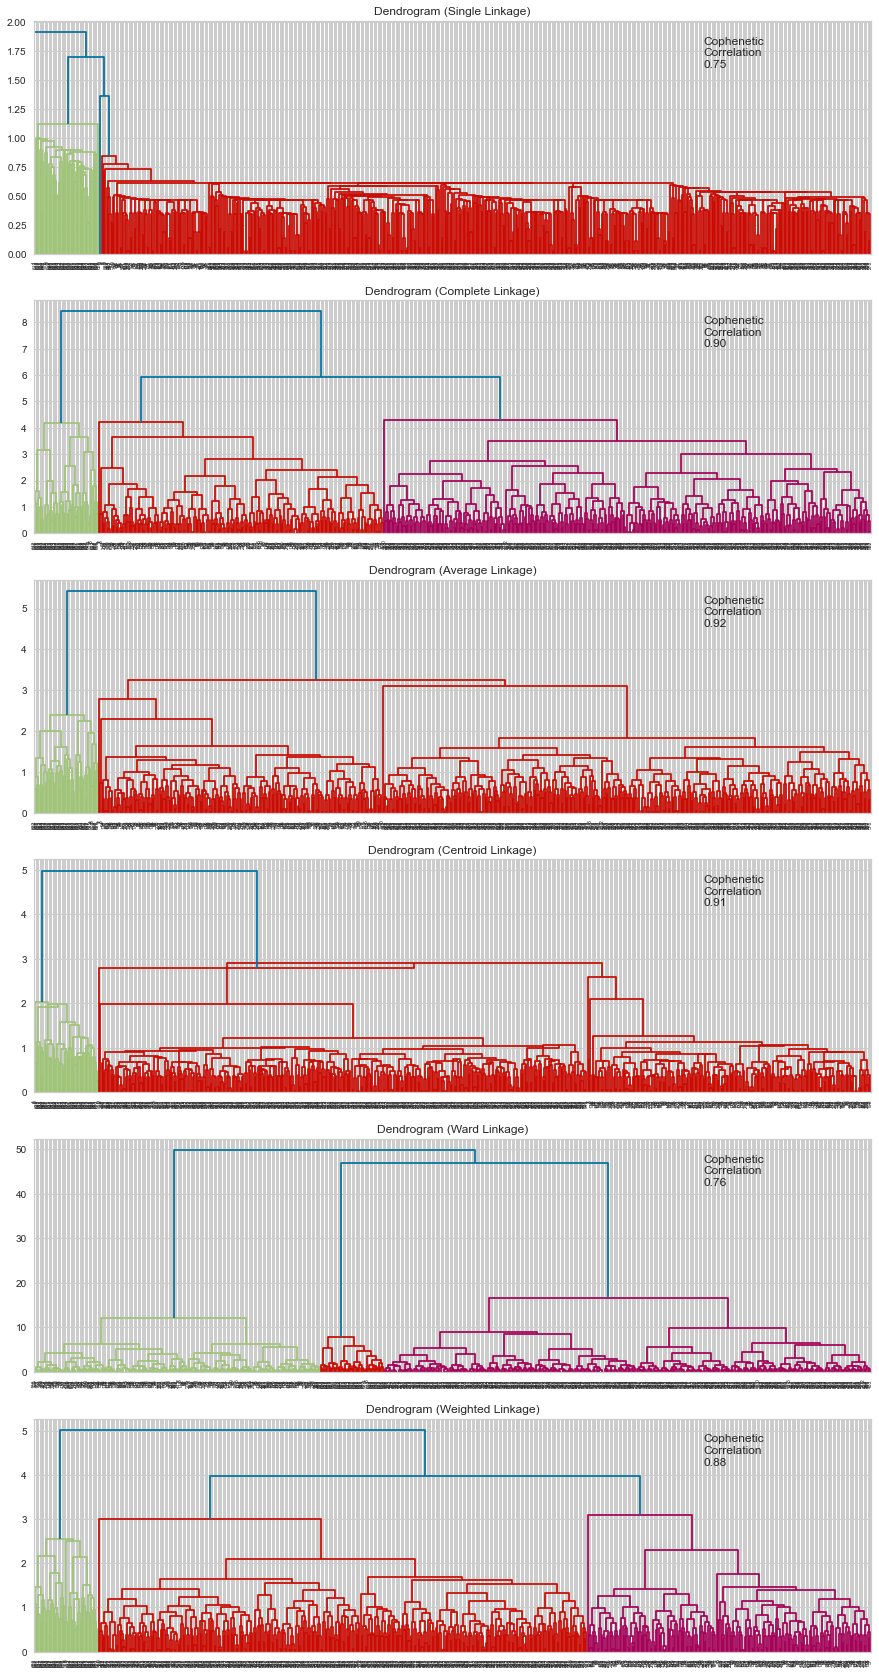

<IPython.core.display.Javascript object>

In [48]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_dfHC, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

#### Evaluation Criteria.

- More distance between vertical lines in the dendrogram indicates a clear separation between the clusters.
- The number of clusters will be determined by the threshold line drawn that intersects the vertical lines.
    - Number of intersections = number of clusters.
- Diagram that has distinct and less overlapping groups has suitable model parameters.
- Model with a high Cophenetic Coefficient is a better model.

In [49]:
# let's create a dataframe to compare cophenetic correlations for each linkage method
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.748153
1,complete,0.899215
2,average,0.916568
3,centroid,0.914617
4,ward,0.763876
5,weighted,0.876066


<IPython.core.display.Javascript object>

Based on the evaluation criteria **3 clusters using "euclidean" distance with "ward" linkage** has decent Cophenetic distance with distinct groupings in dendrogram.

### AgglomerativeClustering based on selected parameters

In [50]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_dfHC)

AgglomerativeClustering(n_clusters=3)

<IPython.core.display.Javascript object>

In [51]:
# adding hierarchical cluster labels to the original and scaled dataframes

subset_scaled_dfHC["HC_Clusters"] = HCmodel.labels_
custDataAttrHC["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

## Cluster Profiling

The goal of Profiling is to differentiate groups (Each group must have unique characteristics.).

In [52]:
cluster_profileHC = custDataAttrHC.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [53]:
cluster_profileHC["count_in_each_segments"] = (
    custDataAttrHC.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [54]:
# let's display cluster profiles
cluster_profileHC.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,34143.236074,5.519894,3.488064,0.978780,1.986737,377
1,12216.216216,2.423423,0.950450,3.554054,6.878378,222
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

There are tree distinct cluster with clearly 3 unique characteristics.

### Plotting 3 clusters against the scaled and original dataset to visualize the distribution.

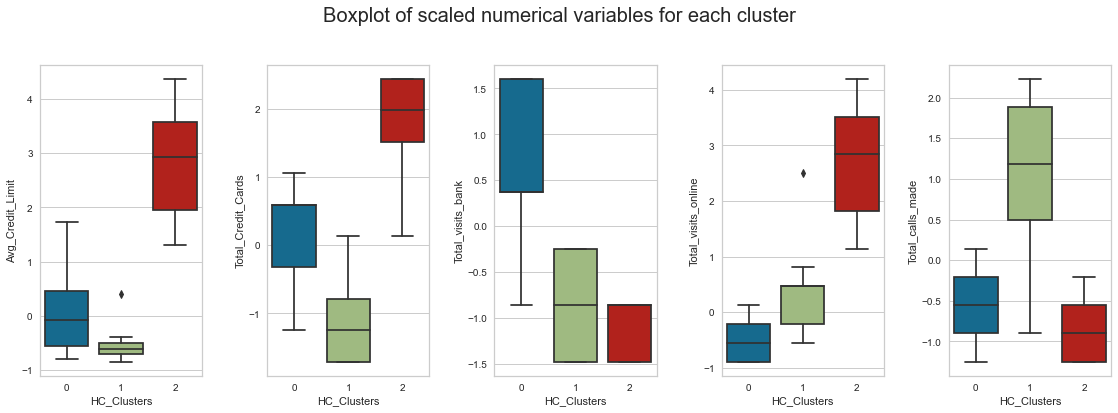

<IPython.core.display.Javascript object>

In [55]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_dfHC[num_col[counter]],
        x=subset_scaled_dfHC["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

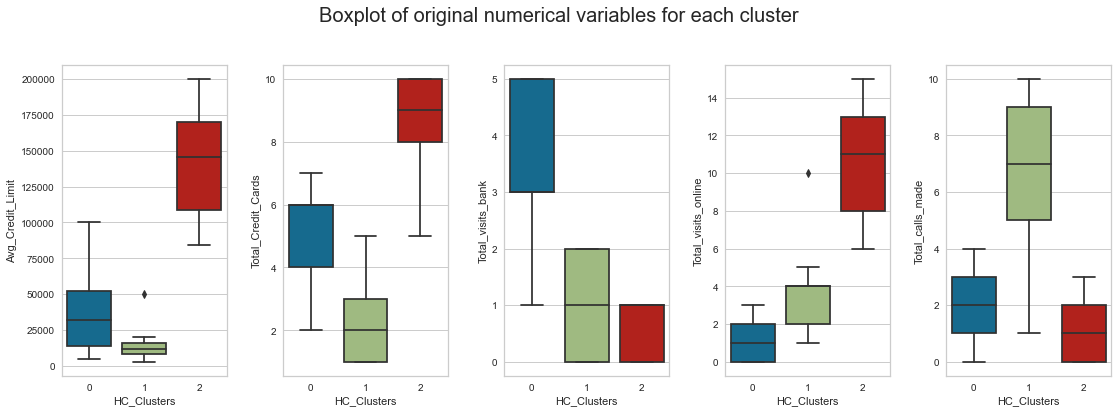

<IPython.core.display.Javascript object>

In [56]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=custDataAttrHC[num_col[counter]], x=custDataAttrHC["HC_Clusters"]
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

In [57]:
# let's display HC cluster profiles for comparison

cluster_profileHC.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,34143.236074,5.519894,3.488064,0.978780,1.986737,377
1,12216.216216,2.423423,0.950450,3.554054,6.878378,222
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

In [58]:
# let's display KMeans cluster profiles for comparison

cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,
0,34071.428571,5.518519,3.484127,0.981481,1.992063,378
1,12239.819005,2.411765,0.945701,3.561086,6.891403,221
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

**Hierarchical clustering and KMeans clustering profiles are almost identical in characteristics and density (size). Both techniques produce same insights.**

- **Cluster 0 (Gold)**:
    - This customer cluster have average credit of 35K - 50K and have 5-6 credit card on an average.
    - These customers prefer personal touch and visits **financial center** more often (3 -5 times a year).
    - This cluster of customers rarely uses online banking and sometimes calls customer banking facility.
    - This cluster of customers can be branded as 'Gold' customers


- **Cluster 1 (Silver)**:
    - This customer cluster has an average credit of 11K - 12K, on the lower end, and has only 2-3 credit cards.
    - These customers prefer **phone banking**, which they make at least 7 - 8 times a year.
    - This cluster of customers rarely uses online banking or visits banking facilities.
    - This cluster of customers can be branded as 'Silver' customers


- **Cluster 2 (Platinum)**:
    - This customer cluster have average credit 140K - 150K and have around 8-10 credit card.
    - They visit the banking center infrequently and use ** online banking** for their needs.
    - They use phone baking very rarely (1-2 times a year)
    - This cluster of customers can be branded as 'Platinum' customers

## Business Recommendations

- Customer's credit limit and banking behavior identify three distinct customer segments.

- **Platinum Customers:**
    - These customers have the following characteristics.
        - Has a higher credit limit. (140K +)
        - Has multiple credit cards. (8 +)
    - These high-end customers like to bank online/mobile, and most like to be reached through collaboration tools like chat or social applications.
    - These customers are good targets for innovative financial technology like 
        - AI-based virtual digital assistance. 
        - voice-based banking through Alexa or Siri, or Cortana.
    - These customers are busy during the daytime and would like to bank during evenings, nights, or weekends. 
    - The best way to retain and target these customers is to give them tools and let them do banking at their own pace and time.
    - Develop an **online banking strategy** to target platinum customers.

- **Gold Customers:**
    - These customers have the following characteristics.
        - Has medium credit limit. (40K -60K)
        - Has a handful of credit cards. (5-6)
    - These middle-class customers like to visit financial centers for banking needs.
    - These customers are most likely to be senior citizens, as they take time to visit the financial center during day times.
    - The best way to retain and target these customers is to give them the personal attention and assign a banking associate.
    - Since most bank needs can be performed online, frequent educational seminars can help them be onboard to online banking.
    - Develop a **financial center banking strategy** to target gold customers and convert them to use online.


- **Silver Customers:**
    - These customers have the following characteristics.
        - Has lower credit limit. (Around 12K)
        - Has few credit cards. (1-2)
    - These low-end customers don't have time to visit a financial center or has no means to access online banking.
    - As the internet is prevalent, it might be easy to onboard them to online banking.
    - Develop a **phone banking strategy** to target silver customers and convert them to use online.


- Bank should employ the following strategy to attract new and retain existing customers.


- **New Customer Strategy**
    - Internet is ubiquitous, and eventually, with proper marketing, all customers will be using online/mobile banking. So enable digital onboarding through technology and the whole onboarding process must easy and quick.
    - Prioritize and make it easy for customers to pay others quickly, invest in peer-to-peer (P2P) payment.
    - Improve time and quality of online services such as money transfer to other banks, bill pay, check deposit, etc.


- **Existing Customer Strategy**
    - Our analysis shows that once customers get used to a banking method, they stick to it.
    - Provide educational seminars for customers who use banking facility to use online.
    - Enhance online banking service to match physical bank service.
    - Assign a personal banking officer to silver customers and develop personal relationships for upselling service.
    - Encourage phone banking customers to use online banking by providing mobile-based voice or chat BOT service.

# Thank you!!

## Appendix - Additional Analysis

### Removing outliers and perform clustering analysis to check changes in segmentation.

In [59]:
custDataAttrIQR = custData.copy()
custDataAttrIQR.shape

(660, 7)

<IPython.core.display.Javascript object>

In [60]:
custDataAttrIQR.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


<IPython.core.display.Javascript object>

### Outlier treatment

Removing all the outliers (8+ times away from the average) from the data set.


In [61]:
# selecting numerical columns
num_colIQR = (
    custDataAttrIQR.iloc[:, 2:].select_dtypes(include=np.number).columns.tolist()
)

for column in num_colIQR:
    print(IQR4(custDataAttrIQR[column], column))

Q1 = 10000.0, Q3 = 48000.0,4*IQR = 152000.0
622    176000
624    178000
630    200000
631    195000
632    187000
637    173000
639    184000
645    171000
646    186000
647    183000
650    195000
654    172000
658    172000
Name: Avg_Credit_Limit, dtype: int64
Q1 = 3.0, Q3 = 6.0,4*IQR = 12.0
Series([], Name: Total_Credit_Cards, dtype: int64)
Q1 = 1.0, Q3 = 4.0,4*IQR = 12.0
Series([], Name: Total_visits_bank, dtype: int64)
Q1 = 1.0, Q3 = 4.0,4*IQR = 12.0
620    15
622    15
628    15
631    15
639    15
640    15
644    15
645    15
653    15
658    15
Name: Total_visits_online, dtype: int64
Q1 = 1.0, Q3 = 5.0,4*IQR = 16.0
Series([], Name: Total_calls_made, dtype: int64)


<IPython.core.display.Javascript object>

In [62]:
outliers = [
    622,
    624,
    630,
    631,
    632,
    637,
    639,
    645,
    646,
    647,
    650,
    654,
    658,
    620,
    628,
    640,
    644,
    653,
]

# Removing all the outliers as these are 8+ times away from the average (average * 8+) and so few in numbers.

custDataAttrIQR.drop(custDataAttrIQR.index[outliers], inplace=True)

<IPython.core.display.Javascript object>

In [63]:
custDataAttrIQR.shape

(642, 7)

<IPython.core.display.Javascript object>

In [64]:
custDataAttrIQR = custDataAttrIQR.iloc[:, 2:]
custDataAttrIQR.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


<IPython.core.display.Javascript object>

## Data Preprocessing

Normalize all features in the data set to a same scale (unit).

In [65]:
# variables used for clustering
num_colIQR

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

<IPython.core.display.Javascript object>

In [66]:
# scaling the dataset before clustering
scalerIQR = StandardScaler()
subsetIQR = custDataAttrIQR[num_colIQR].copy()
subset_scaledIQR = scalerIQR.fit_transform(subsetIQR)

<IPython.core.display.Javascript object>

In [67]:
# creating a dataframe of the scaled columns
subset_scaled_dfIQR = pd.DataFrame(subset_scaledIQR, columns=subsetIQR.columns)

np.random.seed(1)
subset_scaled_dfIQR.sample(n=20)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
179,-0.389238,-1.252899,-0.280565,0.285845,0.118653
533,0.161610,0.684154,0.336294,-0.976856,-0.230775
526,-0.065209,-0.284373,-0.280565,-0.135055,-0.230775
260,-0.518849,-0.284373,1.570010,-0.555956,-1.279060
82,-0.583655,-1.737162,-0.897423,-0.135055,0.468082
498,-0.000404,-0.284373,0.953152,-0.555956,-1.279060
502,0.744861,0.684154,-0.280565,-0.135055,0.118653
306,-0.389238,0.684154,0.336294,-0.976856,-1.279060
378,-0.616057,0.684154,1.570010,-0.135055,-0.929632
521,1.263306,-0.284373,0.336294,-0.135055,-0.580204


<IPython.core.display.Javascript object>

In [68]:
subset_scaled_dfIQR.shape
custDataAttrIQR.shape

(642, 5)

<IPython.core.display.Javascript object>

## K-means Clustering

K-means is a centroid-based algorithm, or a distance-based algorithm, where distances are calculated to assign a point to a cluster. In K-Means, each cluster is associated with a centroid.

The main objective of the K-Means algorithm is to minimize the sum of distances between the points and their respective cluster centroid.

Optimum number of clusters is identified using elbow curve, where the x-axis will represent the number of clusters and the y-axis will be an evaluation metric (pair-wise distances).

Number of Clusters: 1 	Average Distortion: 2.033241493372541
Number of Clusters: 2 	Average Distortion: 1.4321018253237898
Number of Clusters: 3 	Average Distortion: 1.2148513493487183
Number of Clusters: 4 	Average Distortion: 1.1136908705513813
Number of Clusters: 5 	Average Distortion: 1.0442827287691023
Number of Clusters: 6 	Average Distortion: 0.9899438548053556
Number of Clusters: 7 	Average Distortion: 0.9525999056575732
Number of Clusters: 8 	Average Distortion: 0.9276815669598378


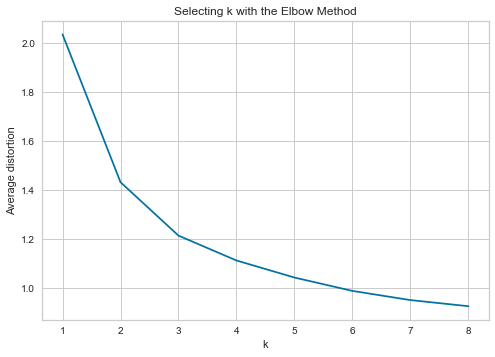

<IPython.core.display.Javascript object>

In [69]:
## K-means Clustering

clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_dfIQR)
    prediction = model.predict(subset_scaled_dfIQR)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_dfIQR, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_dfIQR.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()


**Appropriate value for k **Appropriate value for k seems to be 3 or 4.**

Elbow curve indicates beyond 3 or 4 clusters, model starting to capture noise.seems to be 3 or 4.**

**Silhouette scores comparison**

Silhouette analysis is used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.

For n_clusters = 2, the silhouette score is 0.4396178125327882)
For n_clusters = 3, the silhouette score is 0.507074882942779)
For n_clusters = 4, the silhouette score is 0.3523252830618975)
For n_clusters = 5, the silhouette score is 0.330057112897956)
For n_clusters = 6, the silhouette score is 0.2453823625886809)
For n_clusters = 7, the silhouette score is 0.24203150246675653)
For n_clusters = 8, the silhouette score is 0.23575484773772246)
For n_clusters = 9, the silhouette score is 0.2228877860038417)


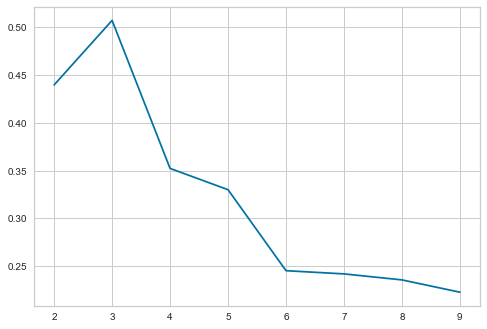

<IPython.core.display.Javascript object>

In [70]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_dfIQR))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_dfIQR, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

Silhouette score 1 means distinct cluster, 0 means close cluster, with border being shared and -1 is the the overlapping cluster. 

**Silhouette score for 3 is highest. So, we will choose 3 as value of k.**

### Silhouette Visualizer

The Silhouette Visualizer displays the silhouette coefficient for each sample on a per-cluster basis, visualizing which clusters are dense and which are not.

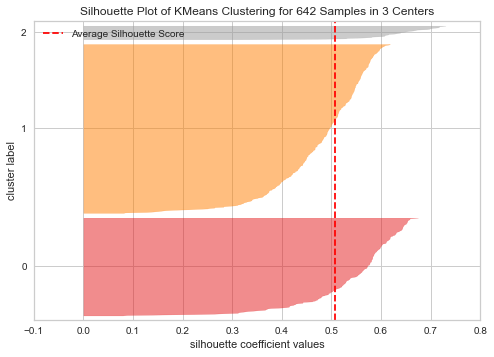

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 642 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [71]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_dfIQR)
visualizer.show()

In [72]:
# let's take 3 as number of clusters
kmeansIQR = KMeans(n_clusters=3, random_state=0)
kmeansIQR.fit(subset_scaled_dfIQR)

KMeans(n_clusters=3, random_state=0)

<IPython.core.display.Javascript object>

In [73]:
# adding kmeans cluster labels to the original and scaled dataframes

custDataAttrIQR["K_means_segments"] = kmeansIQR.labels_
subset_scaled_dfIQR["K_means_segments"] = kmeansIQR.labels_

<IPython.core.display.Javascript object>

## Cluster Profiling

The goal of Profiling is to differentiate groups (Each group must have unique characteristics.).

In [74]:
cluster_profileIQR = custDataAttrIQR.groupby("K_means_segments").mean()

cluster_profileIQR["count_in_each_segments"] = (
    custDataAttrIQR.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [75]:
# let's display cluster profiles
cluster_profileIQR.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,
0,129468.750000,8.625000,0.625000,9.843750,1.218750,32
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,33782.383420,5.515544,3.489637,0.981865,2.000000,386


<IPython.core.display.Javascript object>

There are tree distinct cluster with clearly 3 unique characteristics.

### Plotting 3 clusters against the scaled and original dataset to visualize the distribution.

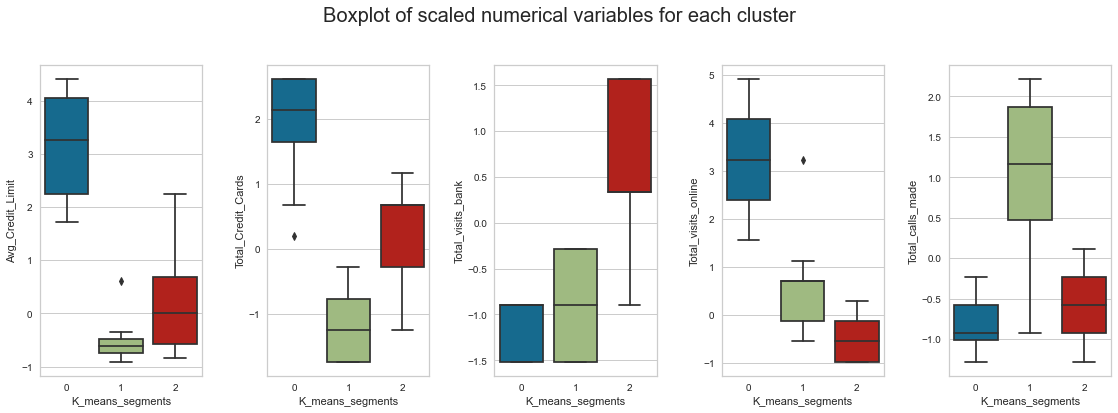

<IPython.core.display.Javascript object>

In [76]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_dfIQR[num_colIQR[counter]],
        x=subset_scaled_dfIQR["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)


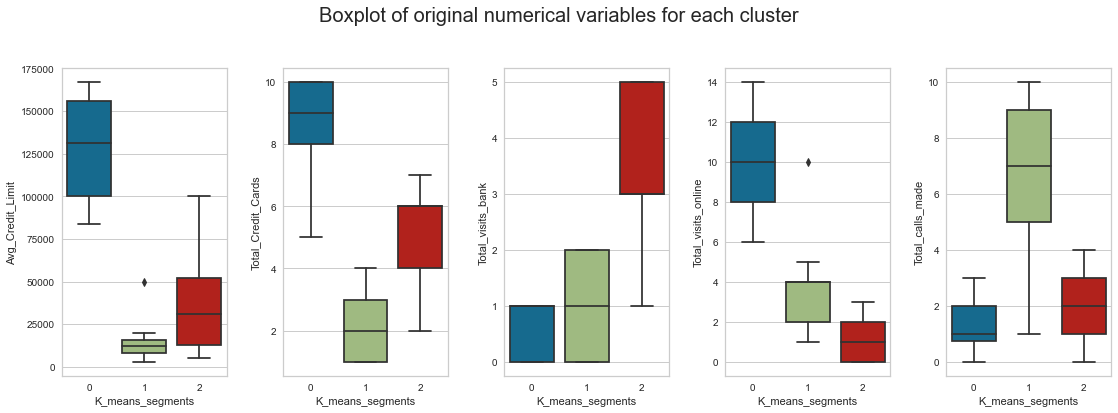

<IPython.core.display.Javascript object>

In [77]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=custDataAttrIQR[num_colIQR[counter]],
        x=custDataAttrIQR["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

In [78]:
# let's display KMeans cluster profiles for comparison

cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,
0,34071.428571,5.518519,3.484127,0.981481,1.992063,378
1,12239.819005,2.411765,0.945701,3.561086,6.891403,221
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

In [79]:
# let's display HC cluster profiles for comparison

cluster_profileHC.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,34143.236074,5.519894,3.488064,0.978780,1.986737,377
1,12216.216216,2.423423,0.950450,3.554054,6.878378,222
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

In [80]:
# let's display IQR cluster profiles for comparison

cluster_profileIQR.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,
0,129468.750000,8.625000,0.625000,9.843750,1.218750,32
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,33782.383420,5.515544,3.489637,0.981865,2.000000,386


<IPython.core.display.Javascript object>

### Insights

- Removing outliers has significant impact on the number of customers in cluster 0 (Platinum customers) and 2 (Gold customers).
- All the dropped outliers has extreme values either in "credit limit" or "visits online" features, which are important characteristics for cluster 0 (Platinum customers).
- Dropped data clearly changes the characteristics of platinum customers.
    - Average credit limit is dropped froom 141 K to 129 K.
    - Total online visit dropped from 10.9 to 9.8.
- Since the center of the cluster 0 (Platinum customers) is changed, it had impacted cluster 2 (Gold customers) size.